# 데이터마이닝


# k-NN & Naive Bayes

## k-NN 분류기(범주형 결과)
* 모델 중심이 아닌 데이터 중심
* 데이터에 대한 가정을 하지 않음
* 간단한 아이디어: 레코드를 유사한 레코드로 분류
* 분류하고자 하는 새로운 레코드의 유사한 k개의 이웃 레코드를 식별
* 이웃 레코드를 사용해 새로운 레코드를 특정 클래스로 분류. 예측 변수 값 X1, X2, ... Xp가 유사한 레코드를 의미
* 이웃 레코드들이 속한 클래스들을 참조하여 분류하고자 하는 레코드에 클래스 할당

## 이웃 결정하기
* 가장 보편적으로 사용되는 거리 측도는 유클리드 거리


## 분류 규칙
* 가장 단순한 경우는 k = 1
* k > 1의 이웃을 갖는 경우
* ** 분류될 레코드와 가장 가까운 k 개의 이웃을 찾는다
* ** 레코드를 분류하기 위해 다수결 결정 규칙을 사용한다. 즉, 레코드는 k개 이웃들의 다수가 속하는 클래스로
분류된다.

In [64]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pylab as plt
import koreanize_matplotlib
import numpy as np

In [4]:
mower_df = pd.read_csv('https://raw.githubusercontent.com/reisanar/datasets/master/RidingMowers.csv')
mower_df['Number'] = mower_df.index + 1
mower_df.head()

,Income,Lot_Size,Ownership,Number
0,60.0,18.4,Owner,1
1,85.5,16.8,Owner,2
2,64.8,21.6,Owner,3
3,61.5,20.8,Owner,4
4,87.0,23.6,Owner,5


In [5]:
trainData, validData = train_test_split(mower_df, test_size = 0.4, random_state= 26)
print(trainData.shape, validData.shape)
newHousehold = pd.DataFrame([{'Income':60, 'Lot_Size':20}])
newHousehold

(14, 4) (10, 4)


,Income,Lot_Size
0,60,20


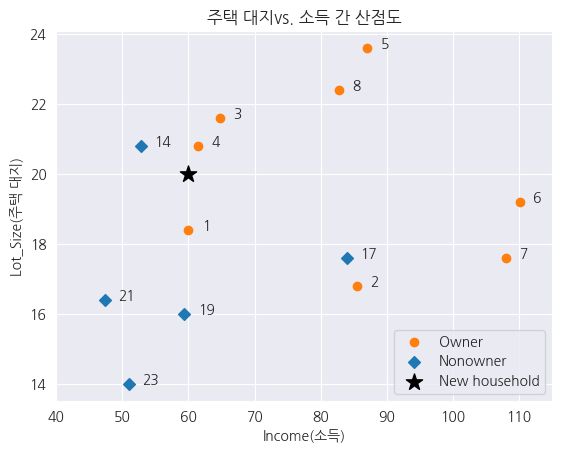

In [8]:
# Scatter Plot
fig, ax = plt.subplots()

subset = trainData.loc[trainData['Ownership']=='Owner']
ax.scatter(subset.Income, subset.Lot_Size, marker = 'o', label = 'Owner', color = 'C1')

subset = trainData.loc[trainData['Ownership']=='Nonowner']
ax.scatter(subset.Income, subset.Lot_Size, marker = 'D', label = 'Nonowner', color = 'C0')

ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker = '*', label = 'New household', color = 'black', s = 150)

plt.title('주택 대지vs. 소득 간 산점도')
plt.xlabel('Income(소득)')
plt.ylabel('Lot_Size(주택 대지)')
for _, row in trainData.iterrows():
    ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(40, 115)
ax.legend(handles, labels, loc = 4)

plt.show()

In [13]:
# 정규화된 학습, 검증 및 전체 데이터 프레임 초기화, 훈련 데이터를 사용하여 변환을 학습
scaler = preprocessing.StandardScaler()
scaler.fit(trainData[['Income', 'Lot_Size']])

# 전체 데이터 반환
mowerNorm = pd.concat([pd.DataFrame(scaler.transform(mower_df[['Income', 'Lot_Size']]),
                                    columns = ['zIncome', 'zLot_Size']),
                       mower_df[['Ownership', 'Number']]], axis = 1)
trainNorm = mowerNorm.iloc[trainData.index]
validNorm = mowerNorm.iloc[validData.index]
newHouseholdNorm = pd.DataFrame(scaler.transform(newHousehold), columns = ['zIncome', 'zLot_Size'])

# Use k-nearest neighbor
knn = NearestNeighbors(n_neighbors=3)
knn.fit(trainNorm[['zIncome', 'zLot_Size']])
distances, indices = knn.kneighbors(newHouseholdNorm)
print(trainNorm.iloc[indices[0],:])    # indices is a list of lists, we are only intereseted in the first element

     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


## 값 선택
* K가 너무 작으면 데이터의 노이즈를 적합할 위험
* k가 너무 크면 이 알고리즘의 주된 장점 중 하나인 데이터의 지역적 구조를 파악할 수 있는 능력을 놓칠 수 있음
* 학습 데이터셋을 사용해 검증 데이터셋의 레코드를 분류한 다음 다양한 값에 대해 오차율을 계산하여 선택 가장 븐루 성능이 좋은 k 선택
* k 가 선택되면 새로운 레코드를 분류하기 위해 학습 데이터셋과 테스트 데이터셋을 훔치고 알고리즘 반복

In [18]:
# 다양한 k에 대한 k-NN의 검증 정확도
train_X = trainNorm[['zIncome', 'zLot_Size']]
train_y = trainNorm['Ownership']
valid_X = validNorm[['zIncome', 'zLot_Size']]
valid_y = validNorm['Ownership']

# Train a classifier for different values of k
results = []
for k in range(1,15):
    knn = KNeighborsClassifier(n_neighbors = k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy':accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1       0.6
1    2       0.7
2    3       0.8
3    4       0.9
4    5       0.7
5    6       0.9
6    7       0.9
7    8       0.9
8    9       0.9
9   10       0.8
10  11       0.8
11  12       0.9
12  13       0.4
13  14       0.4


### k=4에 대한 분류
* K가 선택되면 새로운 레코드를 분류하기 위해 학습/테스트 데이터셋을 합치고 알고리즘 반복

In [19]:
# 전체 데이터 셋에 대한 재훈련
mower_X = mowerNorm[['zIncome', 'zLot_Size']]
mower_y = mowerNorm['Ownership']
knn = KNeighborsClassifier(n_neighbors = 4).fit(mower_X, mower_y)
distances, indices = knn.kneighbors(newHouseholdNorm)
print(knn.predict(newHouseholdNorm))
print('Distances', distances)
print('Indices', indices)
print(mowerNorm.iloc[indices[0],:])

['Owner']
Distances [[0.31358009 0.40880312 0.44793643 0.61217726]]
Indices [[ 3  8 13  0]]
     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
8  -0.069107   0.437269     Owner       9
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


## 레코드 분류의 기본 : 다수결의 원칙
* 근접 이웃들 중 다수가 속한 클래스의 member가 되도록 새로운 레코드 분류
* 즉, 다수 == 클래스 멤버십 확률(레코드가 클래스에 속할 확률에 대한 컷오프 값)
* 소득($60,000) & 주택 크기(20,000m^2)에 대한 근접 이웃
* Owner = 3, Non-owner = 1 -> 0.75
* 코드에서는 'Owner'로 할당

In [20]:
# 전체 데이터셋에 대한 재훈련
mower_X = mowerNorm[['zIncome', 'zLot_Size']]
mower_y = mowerNorm['Ownership']
knn = KNeighborsClassifier(n_neighbors = 4).fit(mower_X, mower_y)
distances, indices = knn.kneighbors(newHouseholdNorm)
print(knn.predict(newHouseholdNorm))
print('Distances', distances)
print('Indices', indices)
print(mowerNorm.iloc[indices[0],:])

['Owner']
Distances [[0.31358009 0.40880312 0.44793643 0.61217726]]
Indices [[ 3  8 13  0]]
     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
8  -0.069107   0.437269     Owner       9
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


## k-NN 알고리즘의 장단점
### 장점
* 단순하다는 것과 모수에 대한 가정이 거의 없다
* 학습 데이터셋이 충분히 많을 때, 특히 각 클래스의 특성이 예측 변수 값들의 여러 조합으로 결정될 때 탁월한 성능

### 단점
* 학습 데이터셋으로부터 모수를 추정하는 데 걸리는 시간은 없어도 학습 데이터 셋이 클 경우에는 근접 이웃을 찾는 데 매우 많은 시간이 소요
* - 극복
* - ** 주성분 분서과 같은 차원 축소 방법으로 차원을 감소시킴으로써 거리 계산 시간을 줄인다
* - ** 근접 이웃을 빨리 찾기 위해 검색 트리와 같은 정교한 데이터 구조를 사용한다
* 학습 데이터셋으로 필요한 레코드의 개수는 예측 변수의 개수 p가 증가함에 따라 기하급수적으로 증가
* 많은 학습 시간이 소요되는 계산이 예측에 집중된 '나태 학습 방법(Lazy Learner)'

## 요약
* 분류할 레코드와 다른 모든 레코드 사이의 거리 찾기
* k-가장 가까운 레코드 선택
* - 가장 가까운 이웃의 다수결에 따라 분류
* - 또는 예측을 위해 가장 가까운 이웃의 평균
* 차원의 저주 - 예측 변수의 수를 제한해야 함

# 07-2. Naive Bayes

## 나이브 베이즈
* 모델 중심이 아닌 데이터 중심
* 데이터에 대한 가정을 하지 않음

## 나이브 베이즈 기본 원리
1. 예측 변수 ㅍ로파일이 동일한(즉, 예측 변수 값들이 동일한) 다른 모든 레코드를 찾음
2. 그 레코드들이 어떤 클래스에 속하고 어떤 클래스가 가장 일반적인지 결정
3. 그 클래스를 새로운 레코드의 답

## 컷오프 확률 방법과 조건부 확률
### 컷오프 확률
1. 어떤 레코드가 해당 클래스에 속한다고 간주하는 값 이상으로 관심 클래스의 컷오프 확률을 설정
2. 새로운 레코드와 도일한 예측 변수 프로파일을 갖는(즉, 예측 변수 값들이 동일한) 모든 학습 레코드를 찾음
3. 그 레코드들이 관심 클래스에 속할 확률을 결정
4. 그 확률이 컷오프 확률보다 크면 새로운 레코드의 답을 관심 클래스로 함

### 조건부 확률
* P(Ci|x1, x2, ..., xp)

## 완전한(정확한) 베이지안 분류기의 적용
* 가장 가능성 있는 클래스에 배정하는 방법의 사용
* 컷오프 확률 방법의 사용
* 완전한(정확한) 베이즈 절차의 실질적 어려움
- 예측 변수의 수가 많아지면(20개 정도만 되어도) 분류할 많은 레코드들과 정확하게 일치하는 것은 없을 것임

## 나이브 베이즈

## 컷오프 확률 방법의 사용

In [21]:
from sklearn.naive_bayes import MultinomialNB
from dmba import classificationSummary, gainsChart
from sklearn.model_selection import train_test_split

In [22]:
delays_df = pd.read_csv('https://raw.githubusercontent.com/niharikabalachandra/Logistic-Regression/master/FlightDelays.csv')
delays_df.head()

,schedtime,carrier,deptime,dest,distance,date,flightnumber,origin,weather,dayweek,daymonth,tailnu,delay
0,1455,OH,1455,JFK,184,1/1/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,1/1/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,1/1/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,1/1/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,1/1/2004,7792,IAD,0,4,1,N698BR,ontime


In [34]:
# 범주형으로 변환
delays_df.dayweek.astype('category')

# 시간별 bin 출발 시간 생성
delays_df.deptime = [round(t / 100) for t in delays_df.deptime]
delays_df.deptime = delays_df.deptime.astype('category')

predictors = ['dayweek', 'deptime', 'origin', 'dest', 'carrier']
outcome = 'delay'

X = pd.get_dummies(delays_df[predictors])
y = (delays_df[outcome] == 'delayed').astype(int)
classes = ['ontime', 'delayed']

# 훈련과 검증 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.40, random_state = 1)

# NB 알고리즘 실행
delays_nb = MultinomialNB(alpha = 0.01)
delays_nb.fit(X_train, y_train)

# 확률 예측
predProb_train = delays_nb.predict_proba(X_train)
predProb_valid = delays_nb.predict_proba(X_valid)

# 클래스 예측
y_valid_pred = delays_nb.predict(X_valid)
y_train_pred = delays_nb.predict(X_train)

In [52]:
# 목적지 공항에 따른 항공기 상태의 피벗 테이블(학습 데이터셋)

# frequency 테이블 구성 후 확률 테이블로 변환
# raw 테이터 프레임을 동일한 random_state를 활용하여 훈련 시험으로 분할
# First cell
# frequency 테이블 구성 후 확률 테이블로 변환
# raw 테이터 프레임을 동일한 random_state를 활용하여 훈련 시험으로 분할
train_df, valid_df = train_test_split(delays_df, test_size=0.4, random_state=1)

# reset all options
pd.reset_option('precision')

pd.set_option('precision',4)
# probability of delay status
print(train_df['delay'].value_counts() / len(train_df))


OptionError: 'Pattern matched multiple keys'

In [49]:
for predictor in predictors:
    # frequency 테이블 구성
    df = train_df[['delay', predictor]]
    freqTable = df.pivot_table(index='delay', columns=predictor, aggfunc=len)

    # 조건부 화률을 얻기 위해 각 행을 행의 합으로 나눠줌
    propTable = freqTable.apply(lambda x: x / sum(x), axis=1)
    print(propTable)
    print()
pd.reset_option('precision')

dayweek         1         2         3         4         5         6         7
delay                                                                        
delayed  0.191571  0.149425  0.114943  0.126437  0.187739  0.068966  0.160920
ontime   0.124646  0.141643  0.144476  0.179415  0.169027  0.135977  0.104816

deptime    0
delay       
delayed  1.0
ontime   1.0

origin        BWI       DCA       IAD
delay                                
delayed  0.080460  0.521073  0.398467
ontime   0.060434  0.647781  0.291785

dest          EWR       JFK       LGA
delay                                
delayed  0.379310  0.199234  0.421456
ontime   0.266289  0.155807  0.577904

carrier        CO        DH        DL        MQ        OH        RU        UA  \
delay                                                                           
delayed  0.057471  0.314176  0.095785  0.222222  0.007663  0.218391  0.015326   
ontime   0.034939  0.229462  0.203966  0.117092  0.010387  0.169027  0.016997   

car

## 새로운 항공기 분류를 위한 계산
* 연착 확률 & 정시 확률 계산 -> 두 값은 분모가 같기 때문에 분자만 비교해도 됨
* 분자는 관련된 예측 변수 값들의 조건부 확률을 곱하고 해당 클래스의 비율을 곱함
* ex) 일요일 오전 10-11시 사이에 DCA-> LGA로 가는 델타 항공기 분류

In [53]:
P_hat_delayed = 0.0958 * 0.1609 * 0.4215 * 0.5211 * 0.1977

P_hat_ontime = 0.2040 * 0.1048 * 0.5779 * 0.6478 * 0.8023

print('P_hat_delayed ~ ', P_hat_delayed)
print('P_hat_ontime ~ ', P_hat_ontime)

print('P(delayed|...) = ', P_hat_delayed / (P_hat_delayed + P_hat_ontime))
print('P(ontime|...) = ', P_hat_ontime / (P_hat_delayed + P_hat_ontime))

P_hat_delayed ~  0.000669340146792383
P_hat_ontime ~  0.00642128403158402
P(delayed|...) =  0.09439791617127381
P(ontime|...) =  0.9056020838287262


### NB를 활용해 데이터의 점수를 구하는 코드

In [58]:
# 데이터 세트에서 검색하여 특정 항공편을 분류
# 동일한 예측 값을 가진 항공편의 경우
# 특정 집합을 부분 집합화
df = pd.concat([pd.DataFrame({'actual': y_valid, 'predicted': y_valid_pred}),
                pd.DataFrame(predProb_valid, index = y_valid.index)], axis = 1)
mask = ((X_valid.carrier_DL == 1) & (X_valid.dayweek == 7) & (X_valid.deptime_0 == 1) & (X_valid.dest_LGA == 1) & (X_valid.origin_DCA == 1))

print(df[mask])

      actual  predicted         0         1
708        0          0  0.939586  0.060414
1228       0          0  0.939586  0.060414
181        0          0  0.939586  0.060414
1226       1          0  0.939586  0.060414
1229       1          0  0.939586  0.060414
705        0          0  0.939586  0.060414
712        0          0  0.939586  0.060414
713        0          0  0.939586  0.060414
1225       0          0  0.939586  0.060414
1754       0          0  0.939586  0.060414
707        0          0  0.939586  0.060414
1749       0          0  0.939586  0.060414
1755       0          0  0.939586  0.060414


### NB를 활용한 항공편 연착에 대한 confusion matrix

In [60]:
# training
classificationSummary(y_train, y_train_pred, class_names = classes)
print()


# validation
classificationSummary(y_valid, y_valid_pred, class_names = classes)

Confusion Matrix (Accuracy 0.8023)

        Prediction
 Actual  ontime delayed
 ontime    1059       0
delayed     261       0

Confusion Matrix (Accuracy 0.8104)

        Prediction
 Actual  ontime delayed
 ontime     714       0
delayed     167       0


### NB에 대한 향상 차트

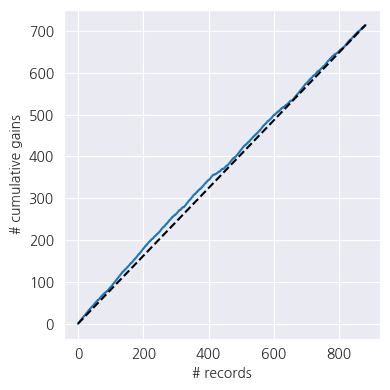

In [62]:
# convert y_valid to a categorical data type
y_valid = y_valid.astype('category')

df = pd.DataFrame({'actual':1-y_valid.cat.codes, 'prob':predProb_valid[:, 0]})
df = df.sort_values(by = ['prob'], ascending = False).reset_index(drop = True)

fig, ax = plt.subplots()
fig.set_size_inches(4,4)
gainsChart(df.actual, ax = ax)

plt.tight_layout()
plt.show()

In [65]:
np.exp(delays_nb.feature_log_prob_)

array([[0.49708304, 0.12572597, 0.00759929, 0.08144331, 0.03668576,
        0.03348031, 0.01959004, 0.072658  , 0.00439384, 0.02885022,
        0.02564477, 0.0147225 , 0.00130711, 0.02125212, 0.00213815,
        0.02742557],
       [0.48845264, 0.12787337, 0.01029317, 0.06663368, 0.05095632,
        0.04850673, 0.02548061, 0.05389582, 0.00735366, 0.04017813,
        0.01225284, 0.02842011, 0.00098473, 0.0279302 , 0.00196457,
        0.00882341]])

---------------------------------------

# 08. Tree & Logistic Regression